In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download abdallahalidev/plantvillage-dataset

 99% 2.03G/2.04G [00:13<00:00, 164MB/s]
100% 2.04G/2.04G [00:13<00:00, 163MB/s]


In [3]:
!unzip plantvillage-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e345153-aed9-4879-a2cc-24f9dc5100e7___UF.GRC_YLCV_Lab 01798_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e37e8ad-3944-4e11-bc10-dd82616274d7___YLCV_NREC 2915_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e382244-fb3a-4caa-af71-05fff25f1c27___UF.GRC_YLCV_Lab 03397_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e3b9886-ce13-49d5-8f80-ccf4e5ddbeac___YLCV_GCREC 5479_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e615038-7a87-446a-a2cd-f76c5c75b6dd___YLCV_GCREC 5144_final_masked.jpg  
  inflating: plantvillage dataset/segmented/Tomato___Tomato_Yellow_Leaf_Curl_Virus/6e6938d9-1ab0-4728-993c-1069b66ce73b___UF.GRC_YLCV_Lab 02727_final_mas

In [1]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import numpy as np
from re import sub
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import metrics

import matplotlib.colors as mcolors

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, Dense


from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image


import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import pydot
import pydotplus
import keras
from tensorflow.keras.utils import plot_model


print("Done importing packages!")

Done importing packages!


In [2]:
def ImagePreprocessingPipeline(img):
    
    # Performing Closing to remove small holes
    kernel = np.ones((1,1),np.uint8)
    closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Color Transformation to HSV for better segmentation
    hsv = cv2.cvtColor(closing, cv2.COLOR_BGR2HSV)

    # find the green color 
    mask_green = cv2.inRange(hsv, (36, 25, 25), (86, 255,255))
    # find the brown color
    mask_brown = cv2.inRange(hsv, (8, 60, 20), (30, 255, 200))
    # find the yellow color in the leaf
    mask_yellow = cv2.inRange(hsv, (21, 39, 64), (40, 255, 255))

    # find any of the three colors(green or brown or yellow) in the image to creat mask
    mask = cv2.bitwise_or(mask_green, mask_brown)
    mask = cv2.bitwise_or(mask, mask_yellow)

    # Bitwise-AND mask and original image to return residual image
    res = cv2.bitwise_and(hsv,img, mask= mask)
    
    # Resized Image
    resizedImg = cv2.resize(res, (128,128))

    return resizedImg

In [8]:
# Preprocessing each image and writing to a seperate folder in same structure as original dataset
rootdir = "plantvillage dataset/color"

preprocessedFolder = 'preprocessed'
if not os.path.exists(preprocessedFolder):
    os.mkdir(preprocessedFolder)

for subdir, dirs, files in tqdm(os.walk(rootdir)):
    classFolder = subdir.split('/')[-1]
    outputFolder = os.path.join(preprocessedFolder, classFolder)
    
    for directory in dirs:
        folder = os.path.join(preprocessedFolder, directory)
        if not os.path.exists(folder):
            os.mkdir(folder)
    
    for file in files:
        inputPath = os.path.join(subdir, file)
        outputPath = os.path.join(outputFolder, file)
        
        img = cv2.imread(inputPath)
        cv2.imwrite(outputPath, ImagePreprocessingPipeline(img))

39it [01:55,  2.97s/it]


In [3]:
# Creating training and validation dataset to return batches of data
BATCH_SIZE = 400
IMG_SIZE = (128, 128)

data_dir = preprocessedFolder
train_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.2,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "training",
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(data_dir,
                                             shuffle=True,
                                             label_mode = 'categorical',
                                             validation_split = 0.2,
                                             batch_size=BATCH_SIZE,
                                             seed = 42,
                                             subset = "validation",
                                             image_size=IMG_SIZE)

Found 54305 files belonging to 38 classes.
Using 43444 files for training.
Found 54305 files belonging to 38 classes.
Using 10861 files for validation.


In [4]:
# Printing all classes of plant leaf diseases present in data
class_names = train_dataset.class_names
num_classes = len(class_names)

for i in range(1, num_classes + 1):
    print(str(i) + ". ", class_names[i - 1])

1.  Apple___Apple_scab
2.  Apple___Black_rot
3.  Apple___Cedar_apple_rust
4.  Apple___healthy
5.  Blueberry___healthy
6.  Cherry_(including_sour)___Powdery_mildew
7.  Cherry_(including_sour)___healthy
8.  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
9.  Corn_(maize)___Common_rust_
10.  Corn_(maize)___Northern_Leaf_Blight
11.  Corn_(maize)___healthy
12.  Grape___Black_rot
13.  Grape___Esca_(Black_Measles)
14.  Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
15.  Grape___healthy
16.  Orange___Haunglongbing_(Citrus_greening)
17.  Peach___Bacterial_spot
18.  Peach___healthy
19.  Pepper,_bell___Bacterial_spot
20.  Pepper,_bell___healthy
21.  Potato___Early_blight
22.  Potato___Late_blight
23.  Potato___healthy
24.  Raspberry___healthy
25.  Soybean___healthy
26.  Squash___Powdery_mildew
27.  Strawberry___Leaf_scorch
28.  Strawberry___healthy
29.  Tomato___Bacterial_spot
30.  Tomato___Early_blight
31.  Tomato___Late_blight
32.  Tomato___Leaf_Mold
33.  Tomato___Septoria_leaf_spot
34.  Tomato_

In [5]:
# Printing size of batches
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 23
Number of test batches: 5


In [5]:
# Pre-Fetching data to load in cache/buffer memory for faster training
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [6]:
# Defining augmentaion layers
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [7]:
# Defining Validation Metrics
METRICS = [
      metrics.CategoricalAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      tfa.metrics.F1Score(num_classes=38, average='macro',threshold=0.5),
]

In [8]:
# Defining pre-trained lightweight base model
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.MobileNetV3Large(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SHAPE,
)

12683000/12683000 [==============================] - 0s 0us/step


In [9]:
# Running one iteration of batch to validate
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(image_batch.shape)

2022-08-17 13:16:08.424859: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204
2022-08-17 13:16:12.308343: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-17 13:16:12.309360: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-17 13:16:12.309413: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-08-17 13:16:12.310225: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-17 13:16:12.310346: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


(400, 128, 128, 3)


In [10]:
# Making all layers of base model trainable
base_model.trainable = True

In [11]:
# Adding global average pooling layer to reduce dimensionality of base model output feature vector
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

print(feature_batch_average.shape)

(400, 960)


In [12]:
# Defining dense layer with softmax activation function to predict probability distribution to predict final output
prediction_layer = tf.keras.layers.Dense(num_classes, activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(400, 38)


In [13]:
# Defining the whole model architecture
inputs = tf.keras.Input(shape=(128, 128, 3))
x = data_augmentation(inputs)
x = base_model(x, training=True)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [14]:
# Defining learning rate and compiling the model with callback setting
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=METRICS)

In [15]:
# Printing model architecture
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 4, 4, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 960)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 38)                36518 

In [16]:
# Defining max number of epochs
initial_epochs = 100

In [17]:
# Defining model checkpoints and callback and then training the model
# Importing required libraries for defining model structure
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Initializing model output directory name
modelNameDirectory = 'PlantLeafDiseaseClassifier'

# Creating model directory if doest not exists
if not os.path.exists(modelNameDirectory):
    os.mkdir(modelNameDirectory)

# Defining model file name
filePath = modelNameDirectory + '/' + 'MobileNetV3_L_BestModel.h5'

# Defining model checkpoint for saving best model
bestModelCheckpoint = ModelCheckpoint(filePath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

# Defining decaying learning rate callback
decayLR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=3)

# Defining early stopping callback
earlystopCheckpoint = EarlyStopping(monitor="val_loss", min_delta=0, patience=9, verbose=1)

# Preparing list of all callbacks
callbacksList = [bestModelCheckpoint, decayLR, earlystopCheckpoint]

# Training the model 
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    callbacks = callbacksList,
                    validation_data=validation_dataset)

Epoch 1/100
109/109 [==============================] - ETA: 0s - loss: 0.6707 - accuracy: 0.8076 - precision: 0.9099 - recall: 0.7538 - f1_score: 0.7516
Epoch 1: val_loss improved from inf to 0.20776, saving model to PlantLeafDiseaseClassifier/MobileNetV3_L_BestModel.h5
109/109 [==============================] - 133s 1s/step - loss: 0.6707 - accuracy: 0.8076 - precision: 0.9099 - recall: 0.7538 - f1_score: 0.7516 - val_loss: 0.2078 - val_accuracy: 0.9338 - val_precision: 0.9496 - val_recall: 0.9199 - val_f1_score: 0.9101 - lr: 0.0010
Epoch 2/100
109/109 [==============================] - ETA: 0s - loss: 0.1851 - accuracy: 0.9382 - precision: 0.9512 - recall: 0.9270 - f1_score: 0.9143
Epoch 2: val_loss improved from 0.20776 to 0.17099, saving model to PlantLeafDiseaseClassifier/MobileNetV3_L_BestModel.h5
109/109 [==============================] - 116s 1s/step - loss: 0.1851 - accuracy: 0.9382 - precision: 0.9512 - recall: 0.9270 - f1_score: 0.9143 - val_loss: 0.1710 - val_accuracy: 0.94

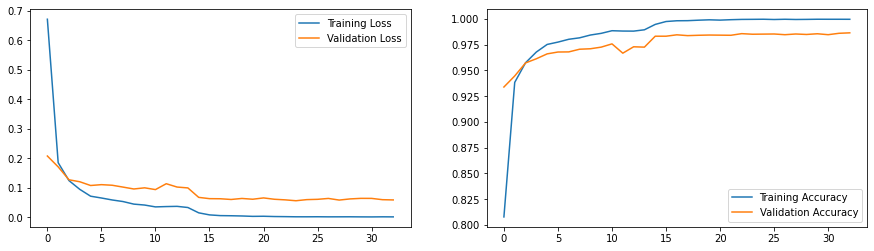

In [18]:
# Plotting Graphs
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
axes[0].plot(history.history['loss'])   
axes[0].plot(history.history['val_loss'])
axes[0].legend(['Training Loss','Validation Loss'])

axes[1].plot(history.history['accuracy'])    
axes[1].plot(history.history['val_accuracy'])
axes[1].legend(['Training Accuracy','Validation Accuracy'])

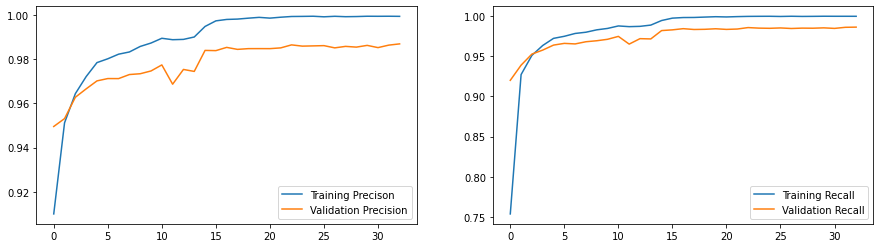

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
axes[0].plot(history.history['precision'])   
axes[0].plot(history.history['val_precision'])
axes[0].legend(['Training Precison','Validation Precision'])

axes[1].plot(history.history['recall'])   
axes[1].plot(history.history['val_recall'])
axes[1].legend(['Training Recall','Validation Recall'])

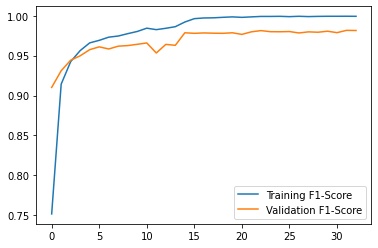

In [20]:
plt.plot(history.history['f1_score'])   
plt.plot(history.history['val_f1_score'])z
plt.legend(['Training F1-Score','Validation F1-Score'])

# Testing

In [6]:
# Loading Plantleaf Disease Classifier MobileNetV3 Large Model
PDC_mobileNetV3Large = tf.keras.models.load_model("MobileNetV3_L_BestModel.h5")

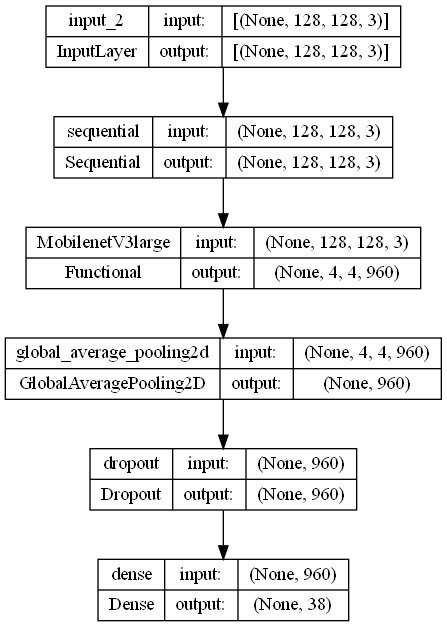

In [7]:
# Plotting Plantleaf Disease Classifier MobileNetV3 Large Model Architecture
keras.utils.vis_utils.pydot = pydotplus
plot_model(PDC_mobileNetV3Large, to_file='PDC_mobileNetV3Large.png', show_shapes=True)

In [8]:
%%time
# Evaluating Plantleaf Disease Classifier MobileNetV3 Large Model
PDC_mobileNetV3Large.evaluate(test_dataset)

5/5 [==============================] - 46s 2s/step - loss: 0.0739 - accuracy: 0.9795 - precision: 0.9805 - recall: 0.9785 - f1_score: 0.9669
Wall time: 46 s


[0.07391121238470078,
 0.9794999957084656,
 0.9804609417915344,
 0.9785000085830688,
 0.966914713382721]

# Prediction Pipeline

In [9]:
# Reading a Single Original Image
image = cv2.imread("../../PlantVillage/plantvillage dataset/color/Apple___Apple_scab/0a769a71-052a-4f19-a4d8-b0f0cb75541c___FREC_Scab 3165.JPG")

In [14]:
%%time
# Preprocessing Image
preprocessedImage = cv2.cvtColor(ImagePreprocessingPipeline(image), cv2.COLOR_BGR2RGB)

# Reshaping Image to feed into model
reshapedImage = preprocessedImage.reshape((1,128,128,3))

# Predicting
PDC_mobileNetV3Large.predict(reshapedImage)

1/1 [==============================] - 0s 24ms/step
Wall time: 61.2 ms


array([[0.02127666, 0.00644257, 0.00268385, 0.02764804, 0.0166176 ,
        0.02446201, 0.00872233, 0.00423926, 0.01158242, 0.00545627,
        0.02069489, 0.00378508, 0.01402383, 0.00912376, 0.00159501,
        0.0454922 , 0.02569291, 0.00170133, 0.01968861, 0.00866837,
        0.01127098, 0.00943581, 0.00144154, 0.00115577, 0.42292187,
        0.0147724 , 0.00173961, 0.00356003, 0.02823689, 0.03842741,
        0.06853084, 0.00766486, 0.02652376, 0.01060032, 0.01662593,
        0.05339609, 0.0012663 , 0.00283253]], dtype=float32)